In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='6'

import tensorflow as tf
from tensorflow.keras import layers, optimizers, models, datasets, regularizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import metrics as sk_metrics
from sklearn.model_selection import train_test_split

import scipy

from datetime import datetime

import PIL
from PIL import Image

In [2]:
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.family'] = 'serif'
dataset_path = "/local/sandbox/DIODE_dataset/"

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [3]:
def ds_args(image):
    image = np.log1p(image)
    if image.shape[-1] == 1:
        image = np.squeeze(image, axis=-1)
    return image, {
        "cmap": "jet", # turbo doesn't exist in mpl 2.2.3
        "vmin": 0.5,
        "vmax": 2.5,
    }
    
def depthshow(image):
    args = ds_args(image)
    plt.imshow(args[0], **args[1])
    plt.axis("off")
    plt.show()

def imgrid(data, is_grid=False):
    print(data.shape)
    if not is_grid and data.shape[0] % 10 == 0:
        data = np.reshape(data, (-1, 10, *data.shape[1:]))
    if data.shape[-1] == 1:
        data = np.reshape(data, data.shape[:-1])
    print(data.shape)
    fig, ax = plt.subplots(data.shape[0], data.shape[1])
    fig.set_size_inches(data.shape[1], data.shape[0])
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            if data.shape[0] == 1:
                args = ds_args(data[y, x])
                ax[x].imshow(args[0], **args[1])
                ax[x].set_axis_off()
            else:
                args = ds_args(data[y, x])
                ax[y][x].imshow(args[0], **args[1])
                ax[y][x].set_axis_off()
    plt.show()
    
def display_images(rgb, *depths):
    fig, ax = plt.subplots(1, 1 + len(depths))
    fig.set_size_inches(2 + len(depths), 1)
    for i in range(1 + len(depths)):
        ax[i].set_axis_off()
    ax[0].imshow(rgb)
    
    with np.errstate(divide='ignore'):
        for i, d in enumerate(depths):
            args = ds_args(d)
            ax[i + 1].imshow(args[0], **args[1])
    plt.show()

In [4]:
all_data = np.load(dataset_path + "DIODE_dataset.npz")

train_rgb = all_data["train_indoors_rgb"] / 255
train_depth = all_data["train_indoors_depth"]
train_depth_mask = all_data["train_indoors_depth_mask"].astype(int)
train_depth_mask = np.expand_dims(train_depth_mask, -1)
val_rgb = all_data["val_indoors_rgb"] / 255
val_depth = all_data["val_indoors_depth"]
val_depth_mask = all_data["val_indoors_depth_mask"].astype(int)
val_depth_mask = np.expand_dims(val_depth_mask, -1)

In [5]:
outdoor_val_rgb = all_data["val_outdoor_rgb"] / 255
outdoor_val_depth = all_data["val_outdoor_depth"]
outdoor_val_depth_mask = all_data["val_outdoor_depth_mask"].astype(int)
outdoor_val_depth_mask = np.expand_dims(outdoor_val_depth_mask, -1)

In [6]:
def interp_depths(depth, depth_mask):
    full_depth = np.zeros_like(depth)
    depth_mask_scan = np.zeros_like(depth_mask)
    
    middle = depth.shape[1] // 2
    depth = depth[:, middle, :, 0]
    depth_mask = depth_mask[:, middle, :, 0]
    depth_mask_scan[:, middle, :, 0] = depth_mask
    
    for i in range(depth.shape[0]):
        indices = np.arange(depth.shape[1])
        masked_depth = depth[i, depth_mask[i].astype(bool)]
        masked_indices = indices[depth_mask[i].astype(bool)]
        
        if len(masked_depth) == 0:
            full_depth_fn = lambda d: np.zeros_like(indices)
        elif len(masked_depth) == 1:
            full_depth_fn = lambda d: np.zeros_like(indices) + np.max(masked_depth)
        else:
            full_depth_fn = scipy.interpolate.interp1d(masked_indices, masked_depth, kind="linear", fill_value="extrapolate", assume_sorted=True)
        interp_scan = full_depth_fn(indices)
        interp_scan = (interp_scan > 0) * interp_scan
        full_depth[i, :, :, 0] = np.repeat(np.expand_dims(interp_scan, 0), full_depth.shape[1], axis=0)
    
    return full_depth, depth_mask_scan

In [7]:
train_depth_scan, train_depth_mask_scan = interp_depths(train_depth, train_depth_mask)
val_depth_scan, val_depth_mask_scan = interp_depths(val_depth, val_depth_mask)

In [8]:
outdoor_val_depth_scan, outdoor_val_depth_mask_scan = interp_depths(outdoor_val_depth, outdoor_val_depth_mask)

In [9]:
print(len(train_rgb), "train samples,", len(val_rgb), "val samples")
print(train_rgb[0].shape)
print(train_depth[0].shape)
print(train_depth_mask[0].shape)
image_shape = train_rgb[0].shape

train_gen = ImageDataGenerator().flow((train_rgb, [train_depth_scan, train_depth_mask_scan, train_depth, train_depth_mask]), train_depth, batch_size=16, shuffle=True)
val_gen = ImageDataGenerator().flow((val_rgb, [val_depth_scan, val_depth_mask_scan, val_depth, val_depth_mask]), val_depth, batch_size=16, shuffle=False)

8574 train samples, 325 val samples
(192, 256, 3)
(192, 256, 1)
(192, 256, 1)


In [10]:
outdoor_val_gen = ImageDataGenerator().flow((outdoor_val_rgb, [outdoor_val_depth_scan, outdoor_val_depth_mask_scan, outdoor_val_depth, outdoor_val_depth_mask]), outdoor_val_depth, batch_size=16, shuffle=False)

In [11]:
reg = regularizers.l2(1e-5)

def conv_block(filters, strides=1, padding='same', sd=0.1):
    return [
        layers.Conv2D(filters, kernel_size=3, strides=strides, padding=padding, kernel_regularizer=reg, activity_regularizer=reg),
        layers.ReLU(),
        layers.SpatialDropout2D(sd),
        #layers.BatchNormalization(renorm=True),
    ]

def tconv_block(filters, strides=1, padding='same', sd=0.1):
    return [
        layers.Conv2DTranspose(filters, kernel_size=3, strides=strides, padding=padding, kernel_regularizer=reg, activity_regularizer=reg),
        layers.ReLU(),
        layers.SpatialDropout2D(sd),
        #layers.BatchNormalization(renorm=True),
    ]

In [ ]:
def make_model():
    rgb_in = layers.Input(image_shape)
    depth_in = layers.Input(image_shape[:2] + (1,))
    depth_mask_in = layers.Input(image_shape[:2] + (1,))
    depth_scan_in = layers.Input(image_shape[:2] + (1,))
    depth_mask_scan_in = layers.Input(image_shape[:2] + (1,))
    
    x_depths = layers.Concatenate()([depth_scan_in, depth_mask_scan_in])
    x = layers.Concatenate()([rgb_in, depth_scan_in])
    
    depth_downscale_blocks = [
        [*conv_block(4)],
        [*conv_block(4, 2)],
        [*conv_block(8, 2)],
        [*conv_block(8, 2)],
        [*conv_block(16, 2)],
        [*conv_block(16, 2)],
    ]
    
    downscale_blocks = [
        [*conv_block(4),
         *conv_block(4)],
        [*conv_block(8, 2),
         *conv_block(8)],
        [*conv_block(16, 2),
         *conv_block(16)],
        [*conv_block(32, 2),
         *conv_block(32)],
        [*conv_block(64, 2),
         *conv_block(64)],
        [*conv_block(128, 2),
         *conv_block(128)],
    ]
    
    middle_blocks = [
        *conv_block(128, 2),
        *conv_block(128),
        *conv_block(128),
        *tconv_block(128, 2)
    ]
    
    upscale_blocks = [
        middle_blocks,
        [*conv_block(128),
         *tconv_block(64, 2)],
        [*conv_block(64),
         *tconv_block(32, 2)],
        [*conv_block(32),
         *tconv_block(16, 2)],
        [*conv_block(16),
         *tconv_block(8, 2)],
        [*conv_block(8),
         *tconv_block(4, 2)],
        [*conv_block(4)],
    ]
        
    downscale_x_depths = [x_depths]
    for block in depth_downscale_blocks:
        x_depths = models.Sequential(block)(downscale_x_depths[-1])
        downscale_x_depths += [x_depths]
    
    downscale_xs = [x]
    for blocks, downscale_x_depth in zip(downscale_blocks, downscale_x_depths):
        x = layers.Concatenate()([x, downscale_x_depth])
        x = models.Sequential(blocks)(downscale_xs[-1])
        downscale_xs += [x]
    
    for blocks, downscale_x, downscale_x_depth in zip(upscale_blocks, reversed(downscale_xs), reversed(downscale_x_depths)):
        x = models.Sequential(blocks)(x)
        x = layers.Concatenate()([x, downscale_x, downscale_x_depth])
    
    final_layers = models.Sequential([
        *conv_block(4),
        layers.Conv2D(1, kernel_size=3, padding="same"),
        layers.ReLU(),
    ])
    
    depth_preds = final_layers(x)
    
    model = models.Model([rgb_in, depth_scan_in, depth_mask_scan_in, depth_in, depth_mask_in], [depth_preds])
    model.summary()
    
    opt = optimizers.Adam(learning_rate=1e-3)
    loss = lambda y_true, y_pred: tf.math.reduce_mean(tf.math.square((tf.math.log(y_true + 1) - tf.math.log(y_pred + 1)) * depth_mask_in))
    metrics = []

    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    
    return model

In [12]:
def make_resnet_model():
    
    rgb_in = layers.Input(image_shape)
    depth_in = layers.Input(image_shape[:2] + (1,))
    depth_mask_in = layers.Input(image_shape[:2] + (1,))
    depth_scan_in = layers.Input(image_shape[:2] + (1,))
    depth_mask_scan_in = layers.Input(image_shape[:2] + (1,))
    
    resnet = ResNet50(include_top=False, weights='imagenet', input_shape=image_shape, input_tensor=rgb_in)
    #resnet.summary()
    
    x_depths = layers.Concatenate()([depth_scan_in, depth_mask_scan_in])
    x = rgb_in
    
    depth_downscale_blocks = [
        [*conv_block(4), *conv_block(4, 2)], # 128
        [*conv_block(8, 2)], # 64
        [*conv_block(16, 2)], # 32
        [*conv_block(32, 2)], # 16
        [*conv_block(64, 2)], # 8
    ]
    
    upscale_blocks = [
        [*conv_block(512),
         *conv_block(512),
         *conv_block(512),
         *conv_block(512),
         *tconv_block(512, 2)], # 16
        [*tconv_block(256, 2)], # 32
        [*tconv_block(128, 2)], # 64
        [*tconv_block(64, 2)], # 128
        [*tconv_block(32, 2)], # 256
    ]
    
    downscale_xs = [rgb_in] + [resnet.layers[i].output for i in [4, 38, 80, 142]]
    # [256, 128, 64, 32, 16]
        
    downscale_x_depths = []
    for block in depth_downscale_blocks:
        downscale_x_depths += [x_depths]
        x_depths = models.Sequential(block)(downscale_x_depths[-1])
        
    x = resnet(x)
    x = layers.Concatenate()([x, x_depths])
    
    for up_blocks, downscale_x, downscale_x_depth in zip(upscale_blocks, reversed(downscale_xs), reversed(downscale_x_depths)):
        x = models.Sequential(up_blocks)(x)
        x = layers.Concatenate()([x, downscale_x, downscale_x_depth])
    
    final_layers = models.Sequential([
        *conv_block(16),
        *conv_block(4),
        layers.Conv2D(1, kernel_size=3, padding="same"),
        layers.ReLU(),
    ])
    
    depth_preds = final_layers(x)
    
    model = models.Model([rgb_in, depth_scan_in, depth_mask_scan_in, depth_in, depth_mask_in], [depth_preds])
    #model.summary()
    
    opt = optimizers.Adam(learning_rate=1e-4)
    loss = lambda y_true, y_pred: tf.math.reduce_mean(tf.math.square((tf.math.log1p(y_true) - tf.math.log1p(y_pred)) * depth_mask_in))
    
    ln_log10 = 2.3025 # ln(10) for conversion from ln to log10
    masked_depth_in = depth_in * depth_mask_in
    masked_depth_pred = depth_preds * depth_mask_in
    def mae(y_true, y_pred):
        return tf.math.reduce_mean(tf.math.abs(masked_depth_in - masked_depth_pred))
    def rmse(y_true, y_pred):
        return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(masked_depth_in - masked_depth_pred)))
    def abs_rel(y_true, y_pred):
        return tf.math.reduce_mean(tf.math.divide_no_nan(tf.math.abs(masked_depth_in - masked_depth_pred), masked_depth_in))
    def log10_mae(y_true, y_pred):
        return tf.math.reduce_mean(tf.math.abs((tf.math.log1p(masked_depth_in) / ln_log10) - (tf.math.log1p(masked_depth_pred) / ln_log10)))
    def log10_rmse(y_true, y_pred):
        return tf.math.sqrt(tf.math.reduce_mean(tf.math.square((tf.math.log1p(masked_depth_in) / ln_log10) - (tf.math.log1p(masked_depth_pred) / ln_log10))))
    metrics = [mae, rmse, abs_rel, log10_mae, log10_rmse]

    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    
    return model

In [41]:
def make_resnet_nolidar_model():
    rgb_in = layers.Input(image_shape)
    depth_in = layers.Input(image_shape[:2] + (1,))
    depth_mask_in = layers.Input(image_shape[:2] + (1,))
    depth_scan_in = layers.Input(image_shape[:2] + (1,))
    depth_mask_scan_in = layers.Input(image_shape[:2] + (1,))
    
    resnet = ResNet50(include_top=False, weights='imagenet', input_shape=image_shape, input_tensor=rgb_in)
    #resnet.summary()
    
    x = rgb_in
    
    upscale_blocks = [
        [*conv_block(512),
         *conv_block(512),
         *conv_block(512),
         *conv_block(512),
         *tconv_block(512, 2)], # 16
        [*tconv_block(256, 2)], # 32
        [*tconv_block(128, 2)], # 64
        [*tconv_block(64, 2)], # 128
        [*tconv_block(32, 2)], # 256
    ]
    
    downscale_xs = [rgb_in] + [resnet.layers[i].output for i in [4, 38, 80, 142]]
    # [256, 128, 64, 32, 16]
        
    x = resnet(x)
    
    for up_blocks, downscale_x in zip(upscale_blocks, reversed(downscale_xs)):
        x = models.Sequential(up_blocks)(x)
        x = layers.Concatenate()([x, downscale_x])
    
    final_layers = models.Sequential([
        *conv_block(16),
        *conv_block(4),
        layers.Conv2D(1, kernel_size=3, padding="same"),
        layers.ReLU(),
    ])
    
    depth_preds = final_layers(x)
    
    model = models.Model([rgb_in, depth_scan_in, depth_mask_scan_in, depth_in, depth_mask_in], [depth_preds])
    #model.summary()
    
    opt = optimizers.Adam(learning_rate=1e-4)
    loss = lambda y_true, y_pred: tf.math.reduce_mean(tf.math.square((tf.math.log1p(y_true) - tf.math.log1p(y_pred)) * depth_mask_in))
    
    ln_log10 = 2.3025 # ln(10) for conversion from ln to log10
    masked_depth_in = depth_in * depth_mask_in
    masked_depth_pred = depth_preds * depth_mask_in
    def mae(y_true, y_pred):
        return tf.math.reduce_mean(tf.math.abs(masked_depth_in - masked_depth_pred))
    def rmse(y_true, y_pred):
        return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(masked_depth_in - masked_depth_pred)))
    def abs_rel(y_true, y_pred):
        return tf.math.reduce_mean(tf.math.divide_no_nan(tf.math.abs(masked_depth_in - masked_depth_pred), masked_depth_in))
    def log10_mae(y_true, y_pred):
        return tf.math.reduce_mean(tf.math.abs((tf.math.log1p(masked_depth_in) / ln_log10) - (tf.math.log1p(masked_depth_pred) / ln_log10)))
    def log10_rmse(y_true, y_pred):
        return tf.math.sqrt(tf.math.reduce_mean(tf.math.square((tf.math.log1p(masked_depth_in) / ln_log10) - (tf.math.log1p(masked_depth_pred) / ln_log10))))
    metrics = [mae, rmse, abs_rel, log10_mae, log10_rmse]

    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    
    return model

In [ ]:
tf.keras.backend.clear_session()

In [13]:
model = make_resnet_model()

In [ ]:
# model.load_weights("models/working_model_no_lidar")
# run_name = datetime.now().strftime("%Y%m%d-%H%M%S") + "-est-resnet"

In [14]:
run_name = datetime.now().strftime("%Y%m%d-%H%M%S") + "-comp-resnet-san"

class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        i = 100
        sample = model.predict([[val_rgb[i]], [val_depth_scan[i]], [val_depth_mask_scan[i]], [val_depth[i]], [val_depth_mask[i]]])
        display_images(val_rgb[i], sample[0], val_depth[i] * val_depth_mask[i])

tensorboard_cb = callbacks.TensorBoard(log_dir="./logs/" + run_name)

curr_epochs = 0

In [15]:
def run_epochs(epochs=100, lr_epoch=100):
    global curr_epochs
    cb = [
        callbacks.LearningRateScheduler(lambda e, l: l if (e + 1) % lr_epoch != 0 else l / 3, verbose=1),
        DisplayCallback(),
        tensorboard_cb,
    ]

    history = model.fit(
        train_gen,
        epochs=(epochs + curr_epochs),
        initial_epoch=curr_epochs,
        validation_data=val_gen,
        callbacks=cb,
    )
    
    curr_epochs += epochs
    return history

def display_samples(indices=[0, 100, 200, 300]):
    samples = model.predict([train_rgb[indices], train_depth_scan[indices], train_depth_mask_scan[indices], train_depth[indices], train_depth_mask[indices]])
    i = 0

    for i in range(4):
        display_images(train_rgb[indices[i]], samples[i], train_depth[indices[i]] * train_depth_mask[indices[i]])

    samples = model.predict([val_rgb[indices], val_depth_scan[indices], val_depth_mask_scan[indices], val_depth[indices], val_depth_mask[indices]])
    i = 0

    for i in range(4):
        display_images(val_rgb[indices[i]], samples[i], val_depth[indices[i]] * val_depth_mask[indices[i]])


Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 1/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 9.8452 - mae: 2.7472 - rmse: 4.2825 - abs_rel: 0.7043 - log10_mae: 0.3413 - log10_rmse: 0.3869

/home/stu5/s4/rtc8537/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


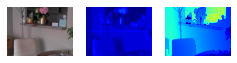

536/536 [==============================] - 916s 1s/step - batch: 267.5000 - size: 15.9963 - loss: 9.8452 - mae: 2.7472 - rmse: 4.2825 - abs_rel: 0.7043 - log10_mae: 0.3413 - log10_rmse: 0.3869 - val_loss: 2.4250 - val_mae: 2.7730 - val_rmse: 3.2710 - val_abs_rel: 0.6339 - val_log10_mae: 0.3144 - val_log10_rmse: 0.3399

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 2/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 1.9498 - mae: 2.4235 - rmse: 4.2411 - abs_rel: 0.5468 - log10_mae: 0.2544 - log10_rmse: 0.3148

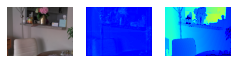

536/536 [==============================] - 529s 987ms/step - batch: 267.5000 - size: 15.9963 - loss: 1.9498 - mae: 2.4235 - rmse: 4.2411 - abs_rel: 0.5468 - log10_mae: 0.2544 - log10_rmse: 0.3148 - val_loss: 1.0774 - val_mae: 2.3430 - val_rmse: 2.8716 - val_abs_rel: 0.4963 - val_log10_mae: 0.2299 - val_log10_rmse: 0.2563

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 3/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 1.0991 - mae: 2.1943 - rmse: 3.9805 - abs_rel: 0.4808 - log10_mae: 0.2117 - log10_rmse: 0.2714

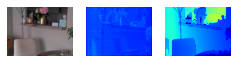

536/536 [==============================] - 528s 984ms/step - batch: 267.5000 - size: 15.9963 - loss: 1.0991 - mae: 2.1943 - rmse: 3.9805 - abs_rel: 0.4808 - log10_mae: 0.2117 - log10_rmse: 0.2714 - val_loss: 0.7945 - val_mae: 2.1612 - val_rmse: 2.7064 - val_abs_rel: 0.4418 - val_log10_mae: 0.1988 - val_log10_rmse: 0.2258

Epoch 00004: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 4/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.8771 - mae: 2.0326 - rmse: 3.8220 - abs_rel: 0.4435 - log10_mae: 0.1858 - log10_rmse: 0.2434

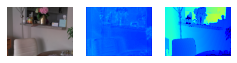

536/536 [==============================] - 529s 986ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.8771 - mae: 2.0326 - rmse: 3.8220 - abs_rel: 0.4435 - log10_mae: 0.1858 - log10_rmse: 0.2434 - val_loss: 0.6743 - val_mae: 1.9469 - val_rmse: 2.4884 - val_abs_rel: 0.3954 - val_log10_mae: 0.1684 - val_log10_rmse: 0.1948

Epoch 00005: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 5/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.7696 - mae: 1.9241 - rmse: 3.6982 - abs_rel: 0.4239 - log10_mae: 0.1699 - log10_rmse: 0.2251

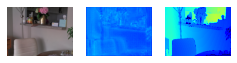

536/536 [==============================] - 529s 987ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.7696 - mae: 1.9241 - rmse: 3.6982 - abs_rel: 0.4239 - log10_mae: 0.1699 - log10_rmse: 0.2251 - val_loss: 0.5842 - val_mae: 1.8865 - val_rmse: 2.4326 - val_abs_rel: 0.3816 - val_log10_mae: 0.1596 - val_log10_rmse: 0.1862

Epoch 00006: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 6/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.6856 - mae: 1.8291 - rmse: 3.5489 - abs_rel: 0.4076 - log10_mae: 0.1571 - log10_rmse: 0.2099

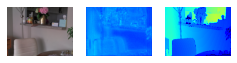

536/536 [==============================] - 529s 987ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.6856 - mae: 1.8291 - rmse: 3.5489 - abs_rel: 0.4076 - log10_mae: 0.1571 - log10_rmse: 0.2099 - val_loss: 0.5120 - val_mae: 1.7668 - val_rmse: 2.3073 - val_abs_rel: 0.3547 - val_log10_mae: 0.1446 - val_log10_rmse: 0.1707

Epoch 00007: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 7/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.6194 - mae: 1.7548 - rmse: 3.4555 - abs_rel: 0.3932 - log10_mae: 0.1476 - log10_rmse: 0.1991

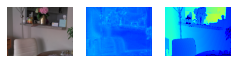

536/536 [==============================] - 529s 987ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.6194 - mae: 1.7548 - rmse: 3.4555 - abs_rel: 0.3932 - log10_mae: 0.1476 - log10_rmse: 0.1991 - val_loss: 0.4642 - val_mae: 1.7705 - val_rmse: 2.3043 - val_abs_rel: 0.3564 - val_log10_mae: 0.1458 - val_log10_rmse: 0.1712

Epoch 00008: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 8/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.5580 - mae: 1.6755 - rmse: 3.3833 - abs_rel: 0.3739 - log10_mae: 0.1376 - log10_rmse: 0.1881

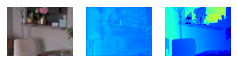

536/536 [==============================] - 529s 988ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.5580 - mae: 1.6755 - rmse: 3.3833 - abs_rel: 0.3739 - log10_mae: 0.1376 - log10_rmse: 0.1881 - val_loss: 0.4169 - val_mae: 1.6276 - val_rmse: 2.1664 - val_abs_rel: 0.3305 - val_log10_mae: 0.1280 - val_log10_rmse: 0.1544

Epoch 00009: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 9/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.5018 - mae: 1.6012 - rmse: 3.2870 - abs_rel: 0.3564 - log10_mae: 0.1288 - log10_rmse: 0.1781

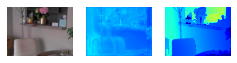

536/536 [==============================] - 530s 988ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.5018 - mae: 1.6012 - rmse: 3.2870 - abs_rel: 0.3564 - log10_mae: 0.1288 - log10_rmse: 0.1781 - val_loss: 0.3697 - val_mae: 1.5234 - val_rmse: 2.0552 - val_abs_rel: 0.3110 - val_log10_mae: 0.1167 - val_log10_rmse: 0.1428

Epoch 00010: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 10/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.4471 - mae: 1.5301 - rmse: 3.2122 - abs_rel: 0.3390 - log10_mae: 0.1203 - log10_rmse: 0.1684

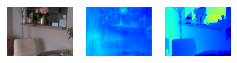

536/536 [==============================] - 531s 991ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.4471 - mae: 1.5301 - rmse: 3.2122 - abs_rel: 0.3390 - log10_mae: 0.1203 - log10_rmse: 0.1684 - val_loss: 0.3419 - val_mae: 1.5931 - val_rmse: 2.1147 - val_abs_rel: 0.3184 - val_log10_mae: 0.1267 - val_log10_rmse: 0.1513

Epoch 00011: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 11/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.4040 - mae: 1.4799 - rmse: 3.1257 - abs_rel: 0.3304 - log10_mae: 0.1150 - log10_rmse: 0.1617

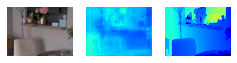

536/536 [==============================] - 531s 990ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.4040 - mae: 1.4799 - rmse: 3.1257 - abs_rel: 0.3304 - log10_mae: 0.1150 - log10_rmse: 0.1617 - val_loss: 0.3007 - val_mae: 1.3283 - val_rmse: 1.8401 - val_abs_rel: 0.2893 - val_log10_mae: 0.0984 - val_log10_rmse: 0.1247

Epoch 00012: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 12/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.3604 - mae: 1.4235 - rmse: 3.0364 - abs_rel: 0.3158 - log10_mae: 0.1087 - log10_rmse: 0.1539

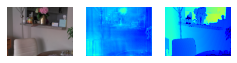

536/536 [==============================] - 531s 991ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.3604 - mae: 1.4235 - rmse: 3.0364 - abs_rel: 0.3158 - log10_mae: 0.1087 - log10_rmse: 0.1539 - val_loss: 0.2650 - val_mae: 1.4061 - val_rmse: 1.9166 - val_abs_rel: 0.2772 - val_log10_mae: 0.1050 - val_log10_rmse: 0.1290

Epoch 00013: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 13/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.3233 - mae: 1.3749 - rmse: 2.9671 - abs_rel: 0.3072 - log10_mae: 0.1040 - log10_rmse: 0.1477

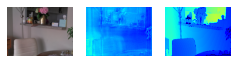

536/536 [==============================] - 531s 991ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.3233 - mae: 1.3749 - rmse: 2.9671 - abs_rel: 0.3072 - log10_mae: 0.1040 - log10_rmse: 0.1477 - val_loss: 0.2428 - val_mae: 1.3378 - val_rmse: 1.8458 - val_abs_rel: 0.2698 - val_log10_mae: 0.0984 - val_log10_rmse: 0.1231

Epoch 00014: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 14/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.2878 - mae: 1.3189 - rmse: 2.8659 - abs_rel: 0.2911 - log10_mae: 0.0981 - log10_rmse: 0.1403

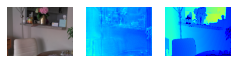

536/536 [==============================] - 530s 990ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.2878 - mae: 1.3189 - rmse: 2.8659 - abs_rel: 0.2911 - log10_mae: 0.0981 - log10_rmse: 0.1403 - val_loss: 0.2150 - val_mae: 1.2664 - val_rmse: 1.7812 - val_abs_rel: 0.2527 - val_log10_mae: 0.0912 - val_log10_rmse: 0.1164

Epoch 00015: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 15/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.2601 - mae: 1.2819 - rmse: 2.7754 - abs_rel: 0.2869 - log10_mae: 0.0951 - log10_rmse: 0.1357

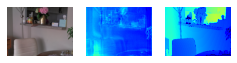

536/536 [==============================] - 530s 988ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.2601 - mae: 1.2819 - rmse: 2.7754 - abs_rel: 0.2869 - log10_mae: 0.0951 - log10_rmse: 0.1357 - val_loss: 0.2137 - val_mae: 1.4171 - val_rmse: 1.8760 - val_abs_rel: 0.2950 - val_log10_mae: 0.1123 - val_log10_rmse: 0.1328

Epoch 00016: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 16/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.2328 - mae: 1.2375 - rmse: 2.7377 - abs_rel: 0.2779 - log10_mae: 0.0910 - log10_rmse: 0.1304

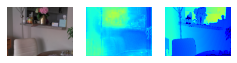

536/536 [==============================] - 530s 989ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.2328 - mae: 1.2375 - rmse: 2.7377 - abs_rel: 0.2779 - log10_mae: 0.0910 - log10_rmse: 0.1304 - val_loss: 0.1868 - val_mae: 1.0844 - val_rmse: 1.5670 - val_abs_rel: 0.2525 - val_log10_mae: 0.0784 - val_log10_rmse: 0.1048

Epoch 00017: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 17/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.2099 - mae: 1.1947 - rmse: 2.6427 - abs_rel: 0.2712 - log10_mae: 0.0876 - log10_rmse: 0.1256

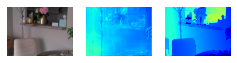

536/536 [==============================] - 531s 990ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.2099 - mae: 1.1947 - rmse: 2.6427 - abs_rel: 0.2712 - log10_mae: 0.0876 - log10_rmse: 0.1256 - val_loss: 0.2786 - val_mae: 1.1915 - val_rmse: 1.8203 - val_abs_rel: 0.2575 - val_log10_mae: 0.0842 - val_log10_rmse: 0.1112

Epoch 00018: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 18/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1977 - mae: 1.1816 - rmse: 2.5901 - abs_rel: 0.2693 - log10_mae: 0.0864 - log10_rmse: 0.1240

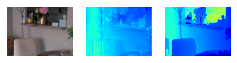

536/536 [==============================] - 530s 989ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1977 - mae: 1.1816 - rmse: 2.5901 - abs_rel: 0.2693 - log10_mae: 0.0864 - log10_rmse: 0.1240 - val_loss: 0.1604 - val_mae: 1.1615 - val_rmse: 1.6596 - val_abs_rel: 0.2463 - val_log10_mae: 0.0825 - val_log10_rmse: 0.1084

Epoch 00019: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 19/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1809 - mae: 1.1455 - rmse: 2.5380 - abs_rel: 0.2636 - log10_mae: 0.0835 - log10_rmse: 0.1198

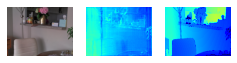

536/536 [==============================] - 530s 989ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1809 - mae: 1.1455 - rmse: 2.5380 - abs_rel: 0.2636 - log10_mae: 0.0835 - log10_rmse: 0.1198 - val_loss: 0.2138 - val_mae: 1.0877 - val_rmse: 1.8745 - val_abs_rel: 0.2679 - val_log10_mae: 0.0773 - val_log10_rmse: 0.1098

Epoch 00020: LearningRateScheduler reducing learning rate to 3.33333324912625e-05.
Epoch 20/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1609 - mae: 1.0905 - rmse: 2.4660 - abs_rel: 0.2429 - log10_mae: 0.0777 - log10_rmse: 0.1132

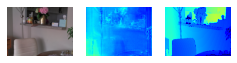

536/536 [==============================] - 531s 990ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1609 - mae: 1.0905 - rmse: 2.4660 - abs_rel: 0.2429 - log10_mae: 0.0777 - log10_rmse: 0.1132 - val_loss: 0.1366 - val_mae: 1.0919 - val_rmse: 1.5832 - val_abs_rel: 0.2234 - val_log10_mae: 0.0775 - val_log10_rmse: 0.1025

Epoch 00021: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 21/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1551 - mae: 1.0755 - rmse: 2.4257 - abs_rel: 0.2421 - log10_mae: 0.0770 - log10_rmse: 0.1117

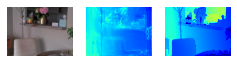

536/536 [==============================] - 531s 990ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1551 - mae: 1.0755 - rmse: 2.4257 - abs_rel: 0.2421 - log10_mae: 0.0770 - log10_rmse: 0.1117 - val_loss: 0.1287 - val_mae: 0.9799 - val_rmse: 1.4687 - val_abs_rel: 0.2110 - val_log10_mae: 0.0684 - val_log10_rmse: 0.0953

Epoch 00022: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 22/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1514 - mae: 1.0636 - rmse: 2.4214 - abs_rel: 0.2406 - log10_mae: 0.0762 - log10_rmse: 0.1105

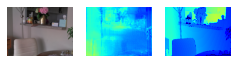

536/536 [==============================] - 531s 990ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1514 - mae: 1.0636 - rmse: 2.4214 - abs_rel: 0.2406 - log10_mae: 0.0762 - log10_rmse: 0.1105 - val_loss: 0.1386 - val_mae: 1.0699 - val_rmse: 1.5525 - val_abs_rel: 0.2595 - val_log10_mae: 0.0796 - val_log10_rmse: 0.1058

Epoch 00023: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 23/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1481 - mae: 1.0584 - rmse: 2.3909 - abs_rel: 0.2382 - log10_mae: 0.0755 - log10_rmse: 0.1097

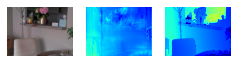

536/536 [==============================] - 531s 991ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1481 - mae: 1.0584 - rmse: 2.3909 - abs_rel: 0.2382 - log10_mae: 0.0755 - log10_rmse: 0.1097 - val_loss: 0.1749 - val_mae: 1.1198 - val_rmse: 1.8000 - val_abs_rel: 0.2369 - val_log10_mae: 0.0801 - val_log10_rmse: 0.1093

Epoch 00024: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 24/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1450 - mae: 1.0472 - rmse: 2.3687 - abs_rel: 0.2368 - log10_mae: 0.0751 - log10_rmse: 0.1088

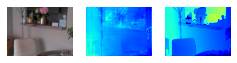

536/536 [==============================] - 530s 990ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1450 - mae: 1.0472 - rmse: 2.3687 - abs_rel: 0.2368 - log10_mae: 0.0751 - log10_rmse: 0.1088 - val_loss: 0.1270 - val_mae: 1.0822 - val_rmse: 1.5665 - val_abs_rel: 0.2204 - val_log10_mae: 0.0773 - val_log10_rmse: 0.1024

Epoch 00025: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 25/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1405 - mae: 1.0324 - rmse: 2.3603 - abs_rel: 0.2338 - log10_mae: 0.0736 - log10_rmse: 0.1071

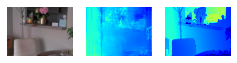

536/536 [==============================] - 531s 991ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1405 - mae: 1.0324 - rmse: 2.3603 - abs_rel: 0.2338 - log10_mae: 0.0736 - log10_rmse: 0.1071 - val_loss: 0.1218 - val_mae: 0.9894 - val_rmse: 1.4826 - val_abs_rel: 0.2139 - val_log10_mae: 0.0691 - val_log10_rmse: 0.0969

Epoch 00026: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 26/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1372 - mae: 1.0279 - rmse: 2.3224 - abs_rel: 0.2335 - log10_mae: 0.0734 - log10_rmse: 0.1059

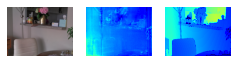

536/536 [==============================] - 531s 990ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1372 - mae: 1.0279 - rmse: 2.3224 - abs_rel: 0.2335 - log10_mae: 0.0734 - log10_rmse: 0.1059 - val_loss: 0.1245 - val_mae: 1.1083 - val_rmse: 1.5846 - val_abs_rel: 0.2265 - val_log10_mae: 0.0809 - val_log10_rmse: 0.1052

Epoch 00027: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 27/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1335 - mae: 1.0134 - rmse: 2.2958 - abs_rel: 0.2284 - log10_mae: 0.0722 - log10_rmse: 0.1047

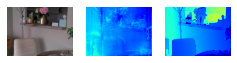

536/536 [==============================] - 531s 991ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1335 - mae: 1.0134 - rmse: 2.2958 - abs_rel: 0.2284 - log10_mae: 0.0722 - log10_rmse: 0.1047 - val_loss: 0.1404 - val_mae: 1.2131 - val_rmse: 1.6969 - val_abs_rel: 0.2441 - val_log10_mae: 0.0898 - val_log10_rmse: 0.1144

Epoch 00028: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 28/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1297 - mae: 1.0040 - rmse: 2.3101 - abs_rel: 0.2267 - log10_mae: 0.0715 - log10_rmse: 0.1034

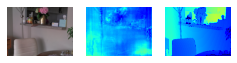

536/536 [==============================] - 531s 991ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1297 - mae: 1.0040 - rmse: 2.3101 - abs_rel: 0.2267 - log10_mae: 0.0715 - log10_rmse: 0.1034 - val_loss: 0.1647 - val_mae: 1.0937 - val_rmse: 1.6868 - val_abs_rel: 0.2390 - val_log10_mae: 0.0805 - val_log10_rmse: 0.1086

Epoch 00029: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 29/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1280 - mae: 1.0004 - rmse: 2.2992 - abs_rel: 0.2232 - log10_mae: 0.0706 - log10_rmse: 0.1031

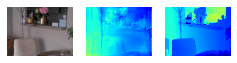

536/536 [==============================] - 531s 990ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1280 - mae: 1.0004 - rmse: 2.2992 - abs_rel: 0.2232 - log10_mae: 0.0706 - log10_rmse: 0.1031 - val_loss: 0.1228 - val_mae: 1.0242 - val_rmse: 1.5395 - val_abs_rel: 0.2326 - val_log10_mae: 0.0744 - val_log10_rmse: 0.1028

Epoch 00030: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 30/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1242 - mae: 0.9880 - rmse: 2.2426 - abs_rel: 0.2227 - log10_mae: 0.0702 - log10_rmse: 0.1013

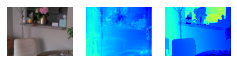

536/536 [==============================] - 531s 990ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1242 - mae: 0.9880 - rmse: 2.2426 - abs_rel: 0.2227 - log10_mae: 0.0702 - log10_rmse: 0.1013 - val_loss: 0.1145 - val_mae: 0.9857 - val_rmse: 1.5275 - val_abs_rel: 0.2074 - val_log10_mae: 0.0685 - val_log10_rmse: 0.0966

Epoch 00031: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 31/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1216 - mae: 0.9770 - rmse: 2.2355 - abs_rel: 0.2191 - log10_mae: 0.0692 - log10_rmse: 0.1004

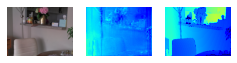

536/536 [==============================] - 531s 991ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1216 - mae: 0.9770 - rmse: 2.2355 - abs_rel: 0.2191 - log10_mae: 0.0692 - log10_rmse: 0.1004 - val_loss: 0.1132 - val_mae: 1.0739 - val_rmse: 1.5548 - val_abs_rel: 0.2188 - val_log10_mae: 0.0760 - val_log10_rmse: 0.1015

Epoch 00032: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 32/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1182 - mae: 0.9711 - rmse: 2.2194 - abs_rel: 0.2162 - log10_mae: 0.0686 - log10_rmse: 0.0993

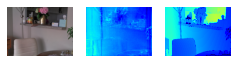

536/536 [==============================] - 531s 990ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1182 - mae: 0.9711 - rmse: 2.2194 - abs_rel: 0.2162 - log10_mae: 0.0686 - log10_rmse: 0.0993 - val_loss: 0.1109 - val_mae: 1.0398 - val_rmse: 1.5288 - val_abs_rel: 0.2094 - val_log10_mae: 0.0739 - val_log10_rmse: 0.1000

Epoch 00033: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 33/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1159 - mae: 0.9580 - rmse: 2.1957 - abs_rel: 0.2136 - log10_mae: 0.0677 - log10_rmse: 0.0982

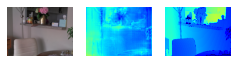

536/536 [==============================] - 531s 990ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1159 - mae: 0.9580 - rmse: 2.1957 - abs_rel: 0.2136 - log10_mae: 0.0677 - log10_rmse: 0.0982 - val_loss: 0.1140 - val_mae: 0.9856 - val_rmse: 1.5186 - val_abs_rel: 0.2408 - val_log10_mae: 0.0726 - val_log10_rmse: 0.1009

Epoch 00034: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 34/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1164 - mae: 0.9632 - rmse: 2.2150 - abs_rel: 0.2162 - log10_mae: 0.0684 - log10_rmse: 0.0994

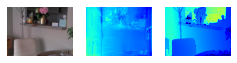

536/536 [==============================] - 533s 995ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1164 - mae: 0.9632 - rmse: 2.2150 - abs_rel: 0.2162 - log10_mae: 0.0684 - log10_rmse: 0.0994 - val_loss: 0.1080 - val_mae: 1.0185 - val_rmse: 1.5034 - val_abs_rel: 0.2129 - val_log10_mae: 0.0713 - val_log10_rmse: 0.0978

Epoch 00035: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 35/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1115 - mae: 0.9448 - rmse: 2.1690 - abs_rel: 0.2118 - log10_mae: 0.0669 - log10_rmse: 0.0971

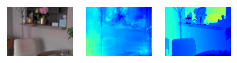

536/536 [==============================] - 530s 989ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1115 - mae: 0.9448 - rmse: 2.1690 - abs_rel: 0.2118 - log10_mae: 0.0669 - log10_rmse: 0.0971 - val_loss: 0.1090 - val_mae: 1.0247 - val_rmse: 1.5551 - val_abs_rel: 0.2248 - val_log10_mae: 0.0732 - val_log10_rmse: 0.1012

Epoch 00036: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 36/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1091 - mae: 0.9408 - rmse: 2.1637 - abs_rel: 0.2115 - log10_mae: 0.0665 - log10_rmse: 0.0961

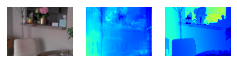

536/536 [==============================] - 531s 990ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1091 - mae: 0.9408 - rmse: 2.1637 - abs_rel: 0.2115 - log10_mae: 0.0665 - log10_rmse: 0.0961 - val_loss: 0.1550 - val_mae: 1.0781 - val_rmse: 1.9431 - val_abs_rel: 0.2312 - val_log10_mae: 0.0754 - val_log10_rmse: 0.1082

Epoch 00037: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 37/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1074 - mae: 0.9331 - rmse: 2.1296 - abs_rel: 0.2104 - log10_mae: 0.0659 - log10_rmse: 0.0954

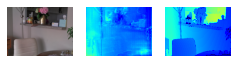

536/536 [==============================] - 531s 990ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1074 - mae: 0.9331 - rmse: 2.1296 - abs_rel: 0.2104 - log10_mae: 0.0659 - log10_rmse: 0.0954 - val_loss: 0.1034 - val_mae: 1.0454 - val_rmse: 1.5171 - val_abs_rel: 0.2169 - val_log10_mae: 0.0753 - val_log10_rmse: 0.1006

Epoch 00038: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 38/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1046 - mae: 0.9226 - rmse: 2.1138 - abs_rel: 0.2071 - log10_mae: 0.0652 - log10_rmse: 0.0943

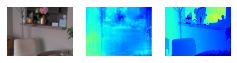

536/536 [==============================] - 530s 989ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1046 - mae: 0.9226 - rmse: 2.1138 - abs_rel: 0.2071 - log10_mae: 0.0652 - log10_rmse: 0.0943 - val_loss: 0.1135 - val_mae: 0.9723 - val_rmse: 1.4460 - val_abs_rel: 0.2528 - val_log10_mae: 0.0745 - val_log10_rmse: 0.1028

Epoch 00039: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 39/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1045 - mae: 0.9251 - rmse: 2.1340 - abs_rel: 0.2081 - log10_mae: 0.0653 - log10_rmse: 0.0945

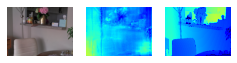

536/536 [==============================] - 531s 990ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1045 - mae: 0.9251 - rmse: 2.1340 - abs_rel: 0.2081 - log10_mae: 0.0653 - log10_rmse: 0.0945 - val_loss: 0.2650 - val_mae: 1.0161 - val_rmse: 1.8388 - val_abs_rel: 0.2439 - val_log10_mae: 0.0764 - val_log10_rmse: 0.1109

Epoch 00040: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 40/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0979 - mae: 0.8947 - rmse: 2.0941 - abs_rel: 0.1972 - log10_mae: 0.0622 - log10_rmse: 0.0913

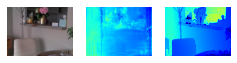

536/536 [==============================] - 531s 990ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0979 - mae: 0.8947 - rmse: 2.0941 - abs_rel: 0.1972 - log10_mae: 0.0622 - log10_rmse: 0.0913 - val_loss: 0.2166 - val_mae: 1.0100 - val_rmse: 2.0264 - val_abs_rel: 0.2376 - val_log10_mae: 0.0717 - val_log10_rmse: 0.1064

Epoch 00041: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 41/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0982 - mae: 0.8980 - rmse: 2.0872 - abs_rel: 0.1981 - log10_mae: 0.0626 - log10_rmse: 0.0916

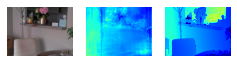

536/536 [==============================] - 531s 990ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0982 - mae: 0.8980 - rmse: 2.0872 - abs_rel: 0.1981 - log10_mae: 0.0626 - log10_rmse: 0.0916 - val_loss: 0.2261 - val_mae: 1.0155 - val_rmse: 1.9786 - val_abs_rel: 0.2408 - val_log10_mae: 0.0739 - val_log10_rmse: 0.1084

Epoch 00042: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 42/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0958 - mae: 0.8880 - rmse: 2.0585 - abs_rel: 0.1971 - log10_mae: 0.0620 - log10_rmse: 0.0903

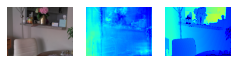

536/536 [==============================] - 530s 989ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0958 - mae: 0.8880 - rmse: 2.0585 - abs_rel: 0.1971 - log10_mae: 0.0620 - log10_rmse: 0.0903 - val_loss: 0.2979 - val_mae: 1.0987 - val_rmse: 2.8669 - val_abs_rel: 0.2656 - val_log10_mae: 0.0731 - val_log10_rmse: 0.1133

Epoch 00043: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 43/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0955 - mae: 0.8849 - rmse: 2.0525 - abs_rel: 0.1967 - log10_mae: 0.0618 - log10_rmse: 0.0902

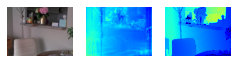

536/536 [==============================] - 531s 990ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0955 - mae: 0.8849 - rmse: 2.0525 - abs_rel: 0.1967 - log10_mae: 0.0618 - log10_rmse: 0.0902 - val_loss: 0.8622 - val_mae: 1.2374 - val_rmse: 3.9455 - val_abs_rel: 0.3111 - val_log10_mae: 0.0767 - val_log10_rmse: 0.1210

Epoch 00044: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 44/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0944 - mae: 0.8809 - rmse: 2.0582 - abs_rel: 0.1947 - log10_mae: 0.0613 - log10_rmse: 0.0896

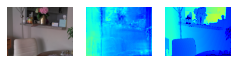

536/536 [==============================] - 531s 991ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0944 - mae: 0.8809 - rmse: 2.0582 - abs_rel: 0.1947 - log10_mae: 0.0613 - log10_rmse: 0.0896 - val_loss: 0.4787 - val_mae: 1.0663 - val_rmse: 2.8287 - val_abs_rel: 0.2667 - val_log10_mae: 0.0717 - val_log10_rmse: 0.1128

Epoch 00045: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 45/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0940 - mae: 0.8782 - rmse: 2.0489 - abs_rel: 0.1966 - log10_mae: 0.0616 - log10_rmse: 0.0895

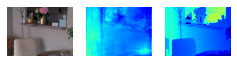

536/536 [==============================] - 530s 990ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0940 - mae: 0.8782 - rmse: 2.0489 - abs_rel: 0.1966 - log10_mae: 0.0616 - log10_rmse: 0.0895 - val_loss: 2.5008 - val_mae: 1.3938 - val_rmse: 5.6967 - val_abs_rel: 0.3563 - val_log10_mae: 0.0787 - val_log10_rmse: 0.1269

Epoch 00046: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 46/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0933 - mae: 0.8750 - rmse: 2.0463 - abs_rel: 0.1939 - log10_mae: 0.0608 - log10_rmse: 0.0893

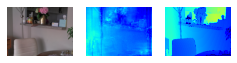

536/536 [==============================] - 531s 992ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0933 - mae: 0.8750 - rmse: 2.0463 - abs_rel: 0.1939 - log10_mae: 0.0608 - log10_rmse: 0.0893 - val_loss: 1.2772 - val_mae: 1.1861 - val_rmse: 2.9952 - val_abs_rel: 0.2515 - val_log10_mae: 0.0808 - val_log10_rmse: 0.1147

Epoch 00047: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 47/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0934 - mae: 0.8742 - rmse: 2.0236 - abs_rel: 0.1949 - log10_mae: 0.0611 - log10_rmse: 0.0893

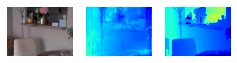

536/536 [==============================] - 532s 993ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0934 - mae: 0.8742 - rmse: 2.0236 - abs_rel: 0.1949 - log10_mae: 0.0611 - log10_rmse: 0.0893 - val_loss: 1.1599 - val_mae: 1.1357 - val_rmse: 2.8357 - val_abs_rel: 0.2454 - val_log10_mae: 0.0760 - val_log10_rmse: 0.1119

Epoch 00048: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 48/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0928 - mae: 0.8729 - rmse: 2.0404 - abs_rel: 0.1939 - log10_mae: 0.0608 - log10_rmse: 0.0892

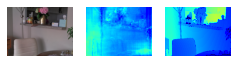

536/536 [==============================] - 532s 992ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0928 - mae: 0.8729 - rmse: 2.0404 - abs_rel: 0.1939 - log10_mae: 0.0608 - log10_rmse: 0.0892 - val_loss: 1.9652 - val_mae: 1.2760 - val_rmse: 4.0843 - val_abs_rel: 0.3043 - val_log10_mae: 0.0799 - val_log10_rmse: 0.1206

Epoch 00049: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 49/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0922 - mae: 0.8735 - rmse: 2.0130 - abs_rel: 0.1957 - log10_mae: 0.0613 - log10_rmse: 0.0890

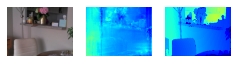

536/536 [==============================] - 531s 991ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0922 - mae: 0.8735 - rmse: 2.0130 - abs_rel: 0.1957 - log10_mae: 0.0613 - log10_rmse: 0.0890 - val_loss: 1.2947 - val_mae: 1.2238 - val_rmse: 3.8988 - val_abs_rel: 0.2934 - val_log10_mae: 0.0761 - val_log10_rmse: 0.1180

Epoch 00050: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 50/50
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0911 - mae: 0.8695 - rmse: 2.0176 - abs_rel: 0.1935 - log10_mae: 0.0606 - log10_rmse: 0.0883

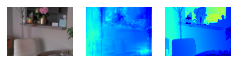

536/536 [==============================] - 533s 995ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0911 - mae: 0.8695 - rmse: 2.0176 - abs_rel: 0.1935 - log10_mae: 0.0606 - log10_rmse: 0.0883 - val_loss: 0.7070 - val_mae: 1.2045 - val_rmse: 3.5210 - val_abs_rel: 0.2889 - val_log10_mae: 0.0779 - val_log10_rmse: 0.1190


In [16]:
history = run_epochs(50, 20)

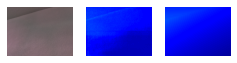

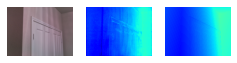

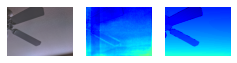

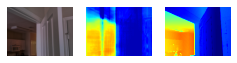

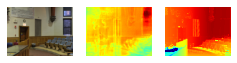

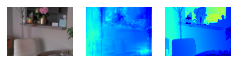

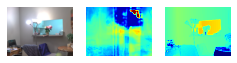

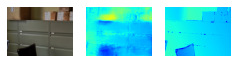

In [17]:
display_samples()

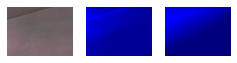

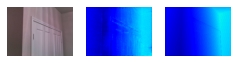

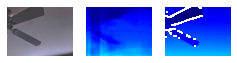

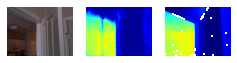

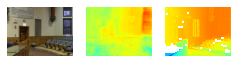

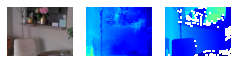

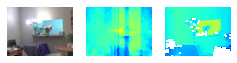

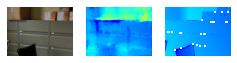

In [18]:
display_samples()

In [20]:
val_pred = model.predict([val_rgb, val_depth_scan, val_depth_mask_scan, val_depth, val_depth_mask])
np.save("output/val_pred_" + run_name, val_pred)

In [19]:
model.evaluate([val_rgb, val_depth_scan, val_depth_mask_scan, val_depth, val_depth_mask], [val_depth])

[0.09391879575183758,
 0.85418075,
 1.9439827,
 0.2187292,
 0.061549112,
 0.098125294]

In [19]:
[m.name for m in model.metrics]

['mae', 'rmse', 'abs_rel', 'log10_mae', 'log10_rmse']

## Numpy Metrics

In [11]:
ln_log10 = 2.3025

def np_mae(y_true, y_pred, mask):
    return np.sum(np.abs(y_true - y_pred)) / np.count_nonzero(mask)
def np_rmse(y_true, y_pred, mask):
    return np.sqrt(np.sum(np.square(y_true - y_pred)) / np.count_nonzero(mask))
def np_abs_rel(y_true, y_pred, mask):
    return np.sum(np.nan_to_num(np.abs(y_true - y_pred) / y_true)) / np.count_nonzero(mask)
def np_log10_mae(y_true, y_pred, mask):
    return np.sum(np.abs((np.log1p(y_true) / ln_log10) - (np.log1p(y_pred) / ln_log10))) / np.count_nonzero(mask)
def np_log10_rmse(y_true, y_pred, mask):
    return np.sqrt(np.sum(np.square((np.log1p(y_true) / ln_log10) - (np.log1p(y_pred) / ln_log10))) / np.count_nonzero(mask))
metrics = [np_mae, np_rmse, np_abs_rel, np_log10_mae, np_log10_rmse]

### Interpolation baseline

In [41]:
for metric in metrics:
    print(metric(val_depth * val_depth_mask, val_depth_scan * val_depth_mask, val_depth_mask))

0.5882732804061788
1.5649141431151479


<ipython-input-24-3423cf76e186>:8: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(np.nan_to_num(np.abs(y_true - y_pred) / y_true)) / np.count_nonzero(mask)


0.17319070655621227
0.04642555026878254
0.09667694710068131


### No lidar baseline

In [42]:
predictions = model.predict([val_rgb, val_depth_scan, val_depth_mask_scan, val_depth, val_depth_mask])
for metric in metrics:
    print(metric(val_depth * val_depth_mask, predictions * val_depth_mask, val_depth_mask))

1.7850146042091557
3.1460106563886194


<ipython-input-24-3423cf76e186>:8: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(np.nan_to_num(np.abs(y_true - y_pred) / y_true)) / np.count_nonzero(mask)


0.45461612431650633
0.14662676982915293
0.201457545189891


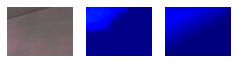

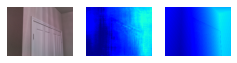

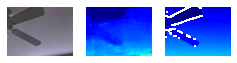

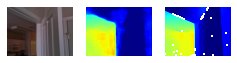

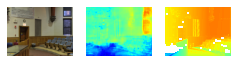

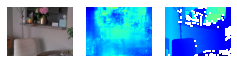

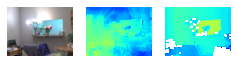

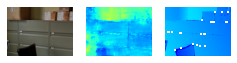

In [44]:
display_samples()

### 2D lidar

In [25]:
model.save_weights("models/final_model/final_model")

In [22]:
# old final model

predictions = model.predict([val_rgb, val_depth_scan, val_depth_mask_scan, val_depth, val_depth_mask])
for metric in metrics:
    print(metric(val_depth * val_depth_mask, predictions * val_depth_mask, val_depth_mask))

0.9083760496611093
2.404540972944217


<ipython-input-21-3423cf76e186>:8: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(np.nan_to_num(np.abs(y_true - y_pred) / y_true)) / np.count_nonzero(mask)


0.22815858906036673
0.06406097214541034
0.10463055377160253


In [18]:
predictions = model.predict([val_rgb, val_depth_scan, val_depth_mask_scan, val_depth, val_depth_mask])

In [20]:
for metric in metrics:
    print(metric(val_depth * val_depth_mask, predictions * val_depth_mask, val_depth_mask))

1.2483967541400247
5.524394509684521


<ipython-input-19-3423cf76e186>:8: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(np.nan_to_num(np.abs(y_true - y_pred) / y_true)) / np.count_nonzero(mask)


0.2976412910636011
0.08014432889954512
0.13472227772150644


## Final Display

In [12]:
interp_preds = val_depth_scan
lidarless_preds = np.load("output/val_pred_20220412-030959-est-resnet.npy")
lidar_preds = np.load("output/val_pred_20220424-213022-comp-resnet-san.npy")

0


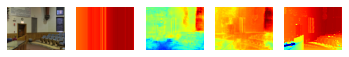

1


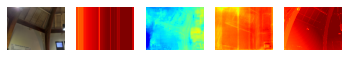

2


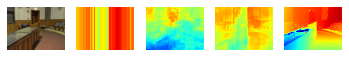

3


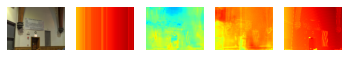

4


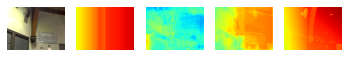

5


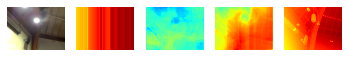

6


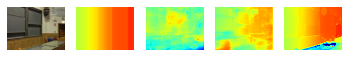

7


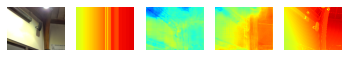

8


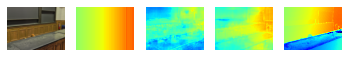

9


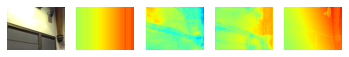

10


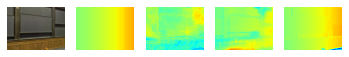

11


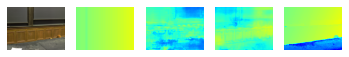

12


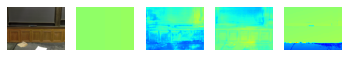

13


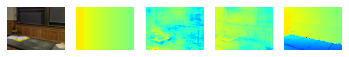

14


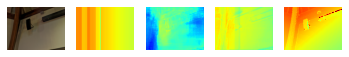

15


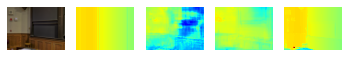

16


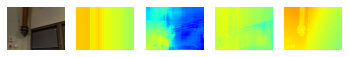

17


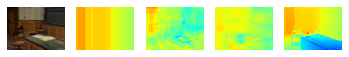

18


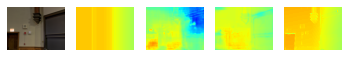

19


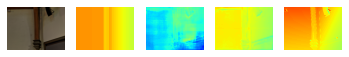

20


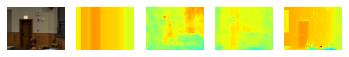

21


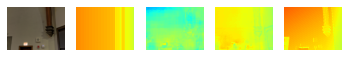

22


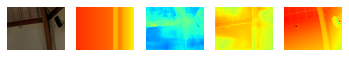

23


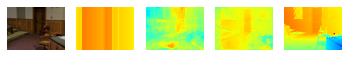

24


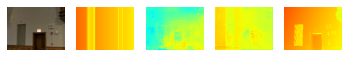

25


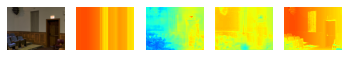

26


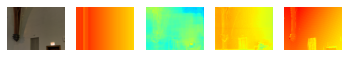

27


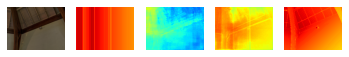

28


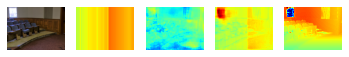

29


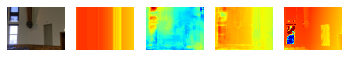

30


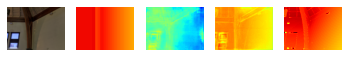

31


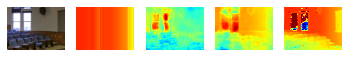

32


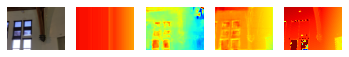

33


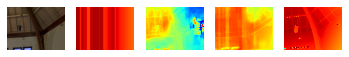

34


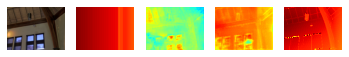

35


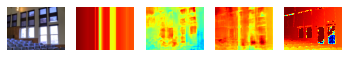

36


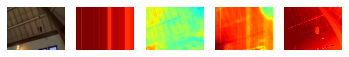

37


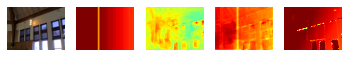

38


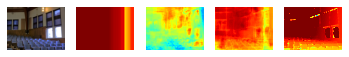

39


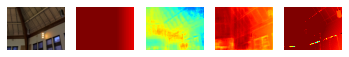

40


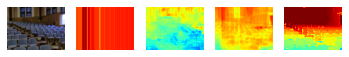

41


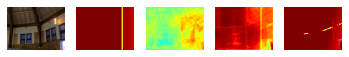

42


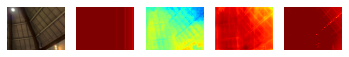

43


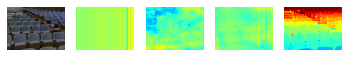

44


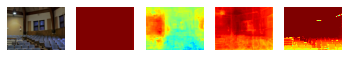

45


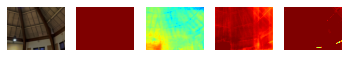

46


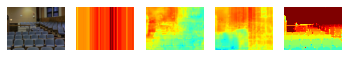

47


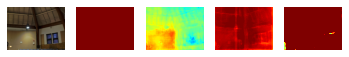

48


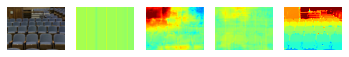

49


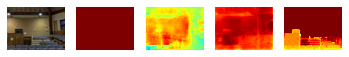

In [51]:
for i in range(0, 50):
    print(i)
    display_images(val_rgb[i], interp_preds[i], lidarless_preds[i], lidar_preds[i], val_depth[i])

50


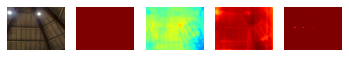

51


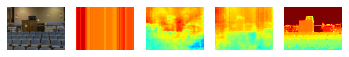

52


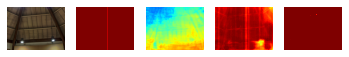

53


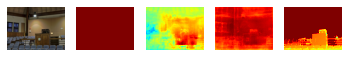

54


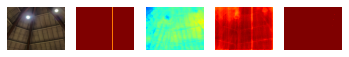

55


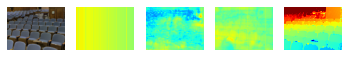

56


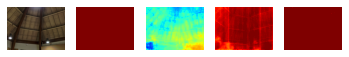

57


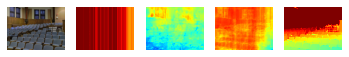

58


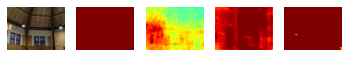

59


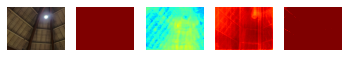

60


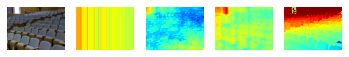

61


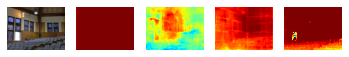

62


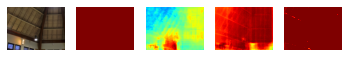

63


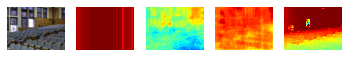

64


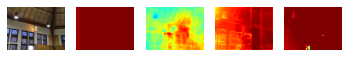

65


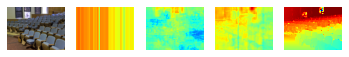

66


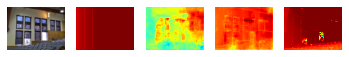

67


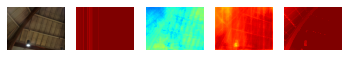

68


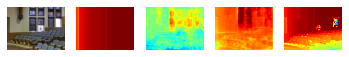

69


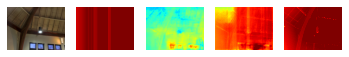

70


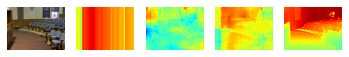

71


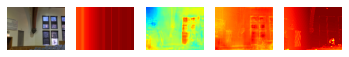

72


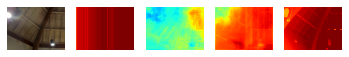

73


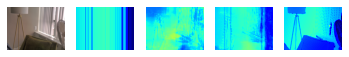

74


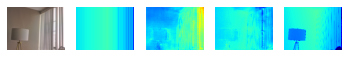

75


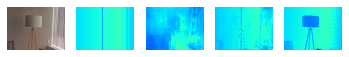

76


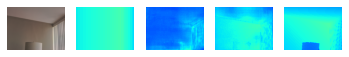

77


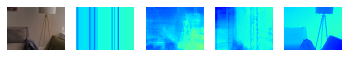

78


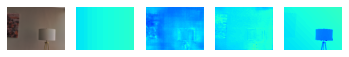

79


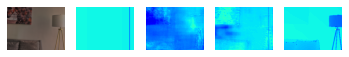

80


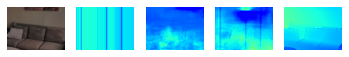

81


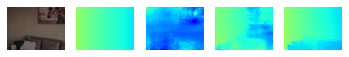

82


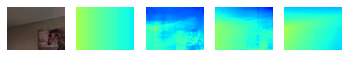

83


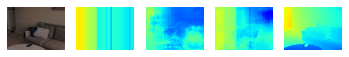

84


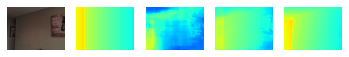

85


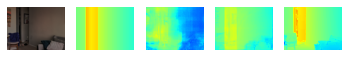

86


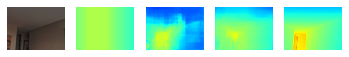

87


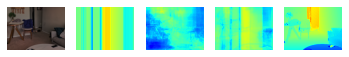

88


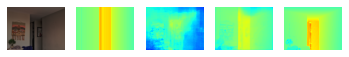

89


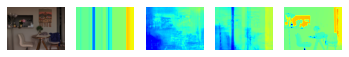

90


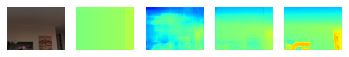

91


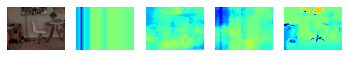

92


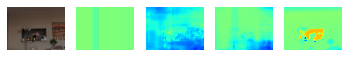

93


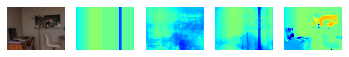

94


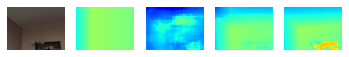

95


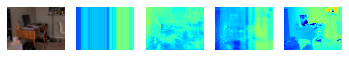

96


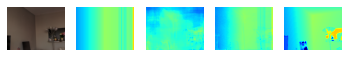

97


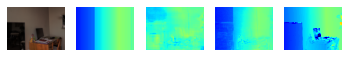

98


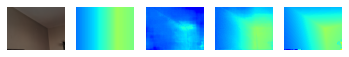

99


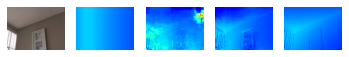

In [52]:
for i in range(50, 100):
    print(i)
    display_images(val_rgb[i], interp_preds[i], lidarless_preds[i], lidar_preds[i], val_depth[i])

100


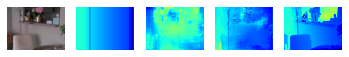

101


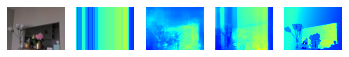

102


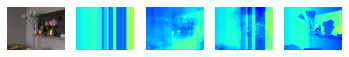

103


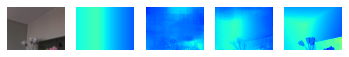

104


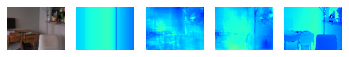

105


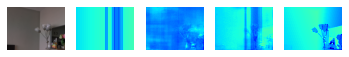

106


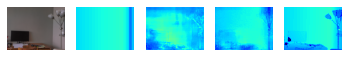

107


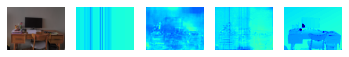

108


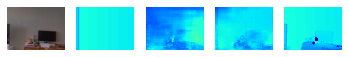

109


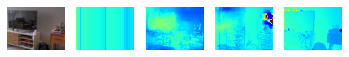

110


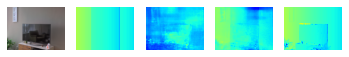

111


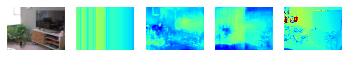

112


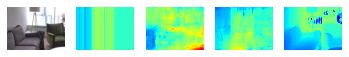

113


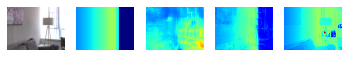

114


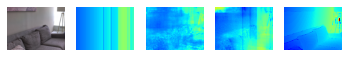

115


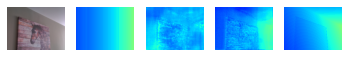

116


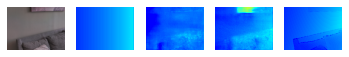

117


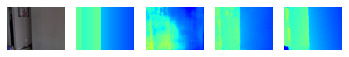

118


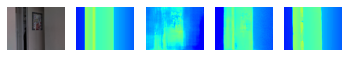

119


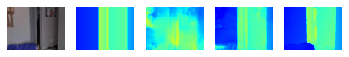

120


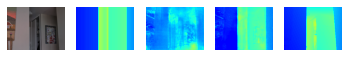

121


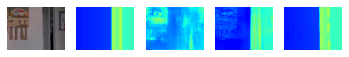

122


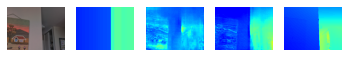

123


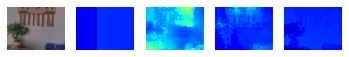

124


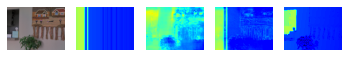

125


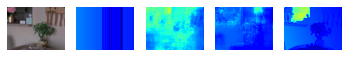

126


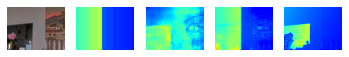

127


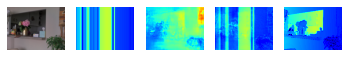

128


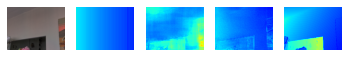

129


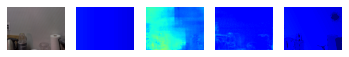

130


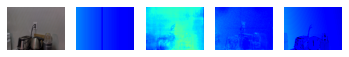

131


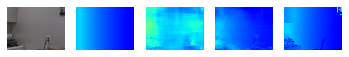

132


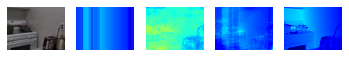

133


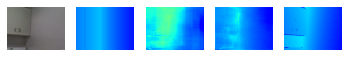

134


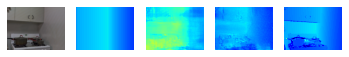

135


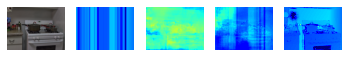

136


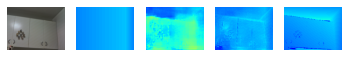

137


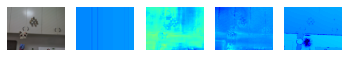

138


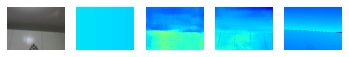

139


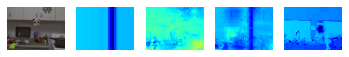

140


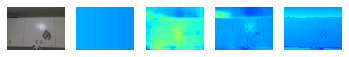

141


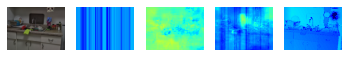

142


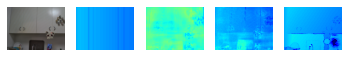

143


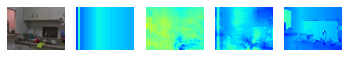

144


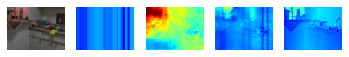

145


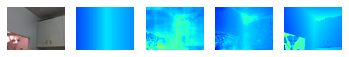

146


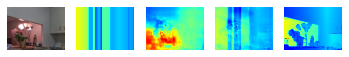

147


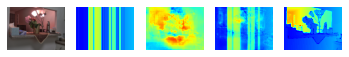

148


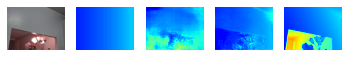

149


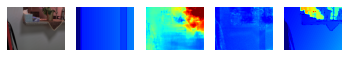

In [53]:
for i in range(100, 150):
    print(i)
    display_images(val_rgb[i], interp_preds[i], lidarless_preds[i], lidar_preds[i], val_depth[i])

150


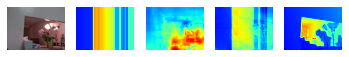

151


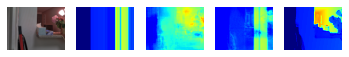

152


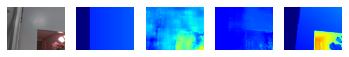

153


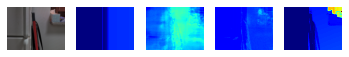

154


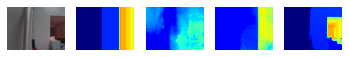

155


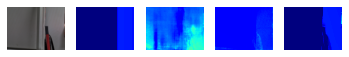

156


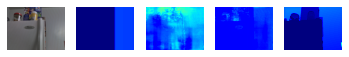

157


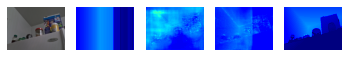

158


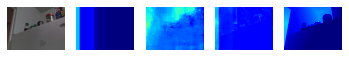

159


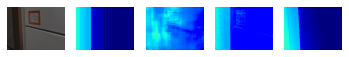

160


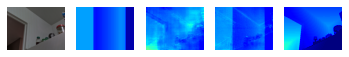

161


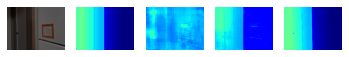

162


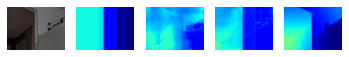

163


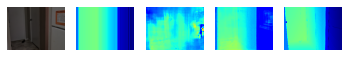

164


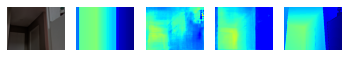

165


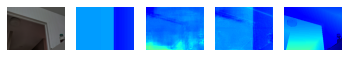

166


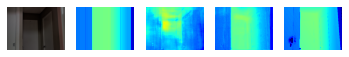

167


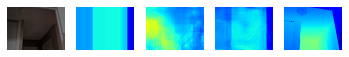

168


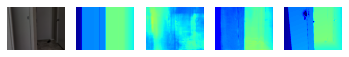

169


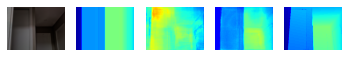

170


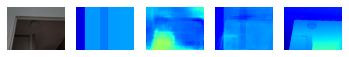

171


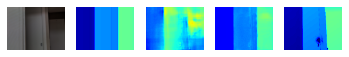

172


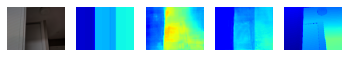

173


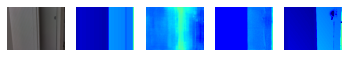

174


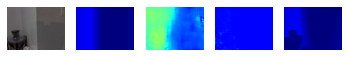

175


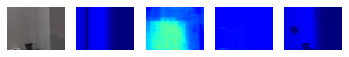

176


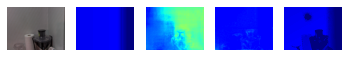

177


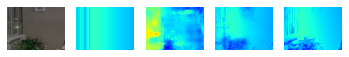

178


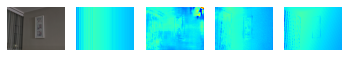

179


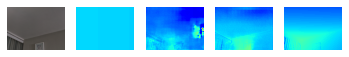

180


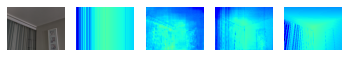

181


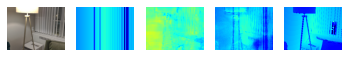

182


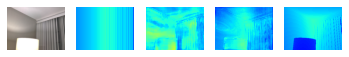

183


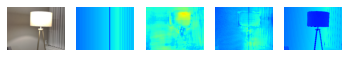

184


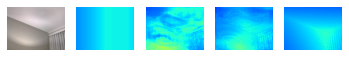

185


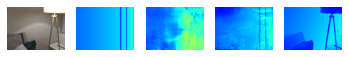

186


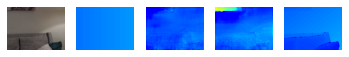

187


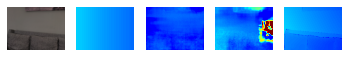

188


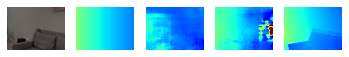

189


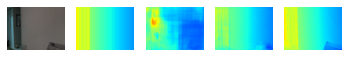

190


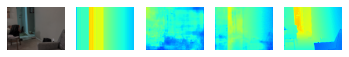

191


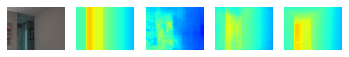

192


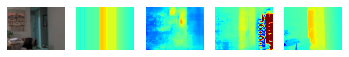

193


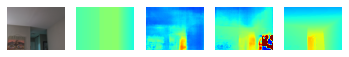

194


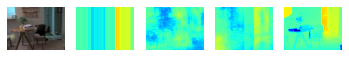

195


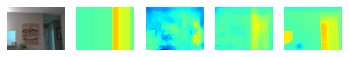

196


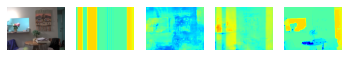

197


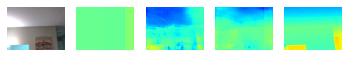

198


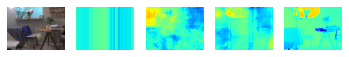

199


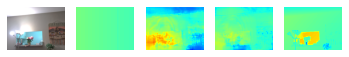

In [54]:
for i in range(150, 200):
    print(i)
    display_images(val_rgb[i], interp_preds[i], lidarless_preds[i], lidar_preds[i], val_depth[i])

200


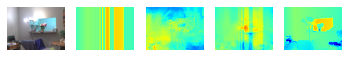

201


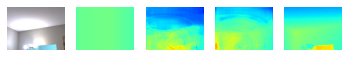

202


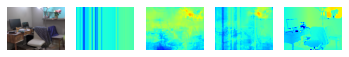

203


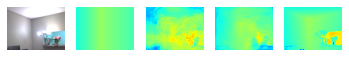

204


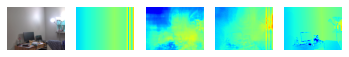

205


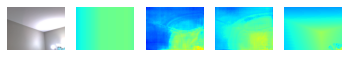

206


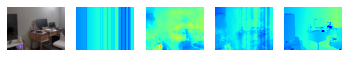

207


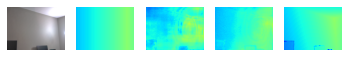

208


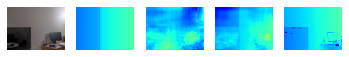

209


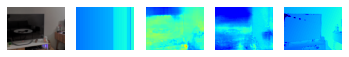

210


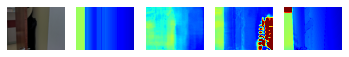

211


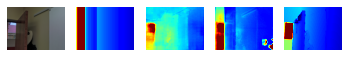

212


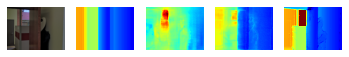

213


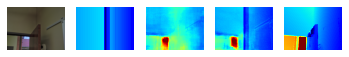

214


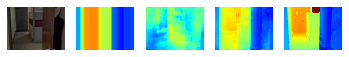

215


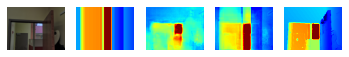

216


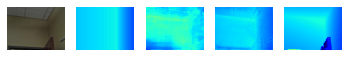

217


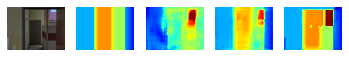

218


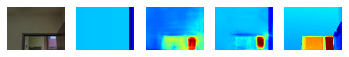

219


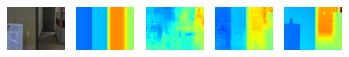

220


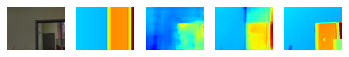

221


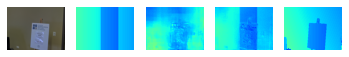

222


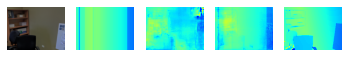

223


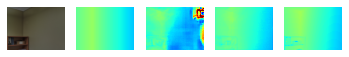

224


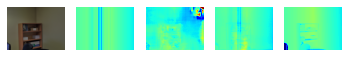

225


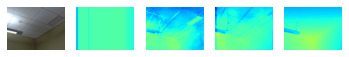

226


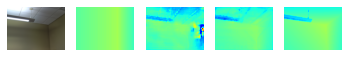

227


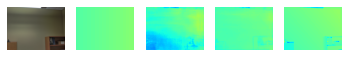

228


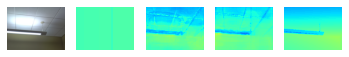

229


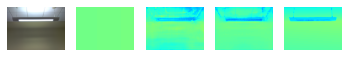

230


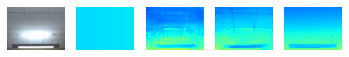

231


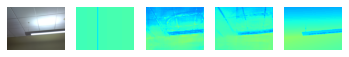

232


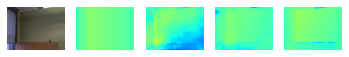

233


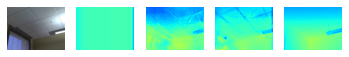

234


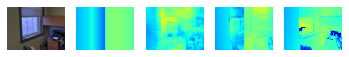

235


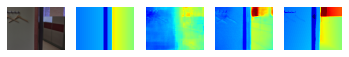

236


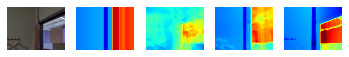

237


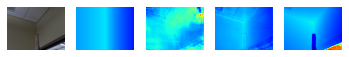

238


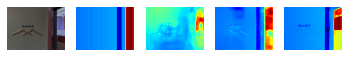

239


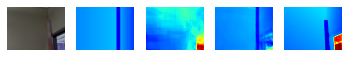

240


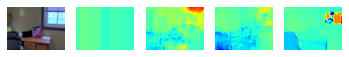

241


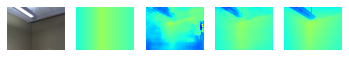

242


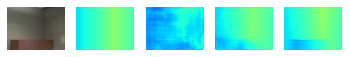

243


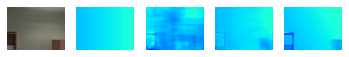

244


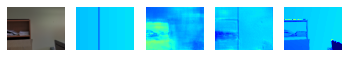

245


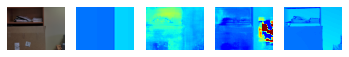

246


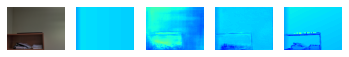

247


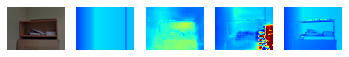

248


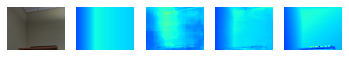

249


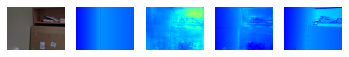

In [55]:
for i in range(200, 250):
    print(i)
    display_images(val_rgb[i], interp_preds[i], lidarless_preds[i], lidar_preds[i], val_depth[i])

250


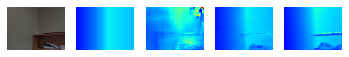

251


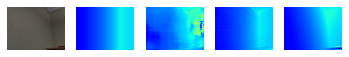

252


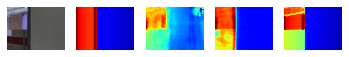

253


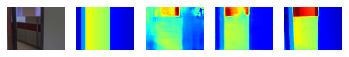

254


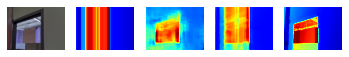

255


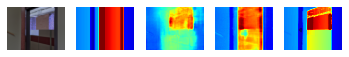

256


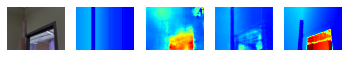

257


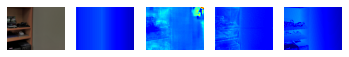

258


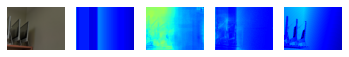

259


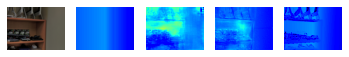

260


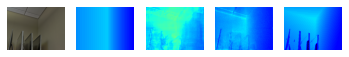

261


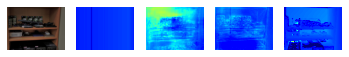

262


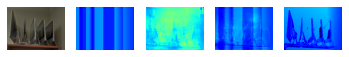

263


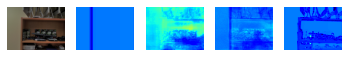

264


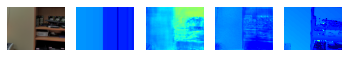

265


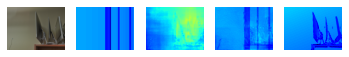

266


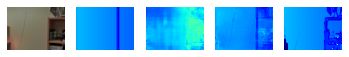

267


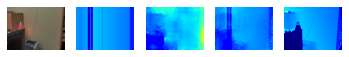

268


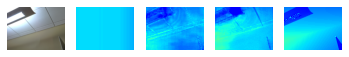

269


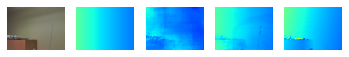

270


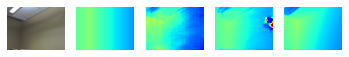

271


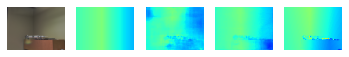

272


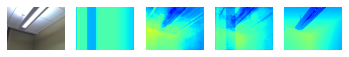

273


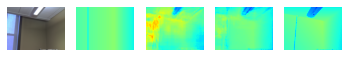

274


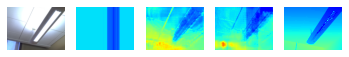

275


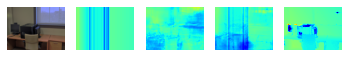

276


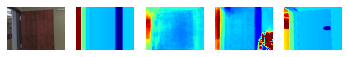

277


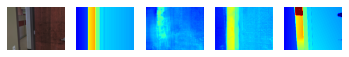

278


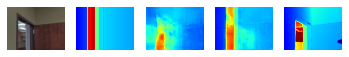

279


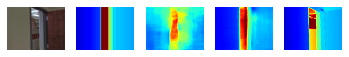

280


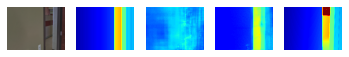

281


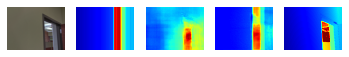

282


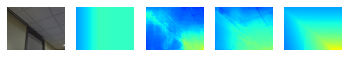

283


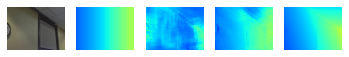

284


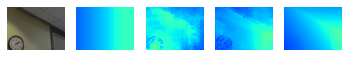

285


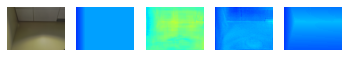

286


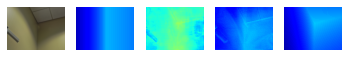

287


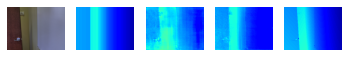

288


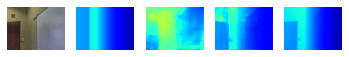

289


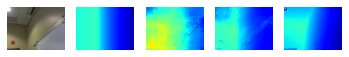

290


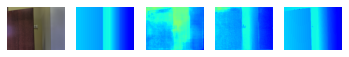

291


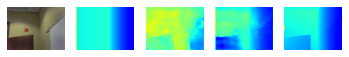

292


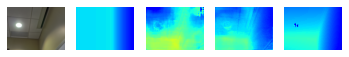

293


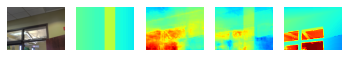

294


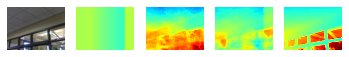

295


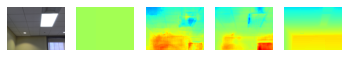

296


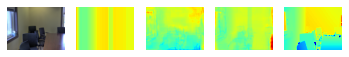

297


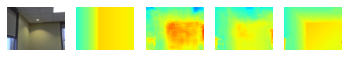

298


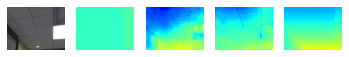

299


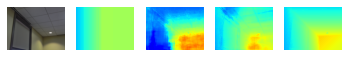

In [58]:
for i in range(250, 300):
    print(i)
    display_images(val_rgb[i], interp_preds[i], lidarless_preds[i], lidar_preds[i], val_depth[i])

300


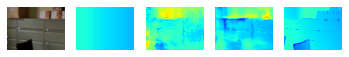

301


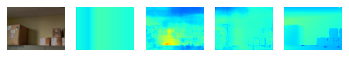

302


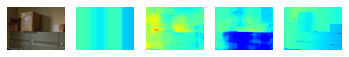

303


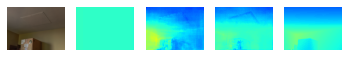

304


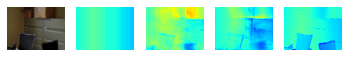

305


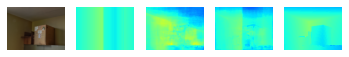

306


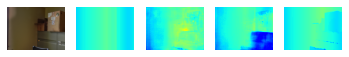

307


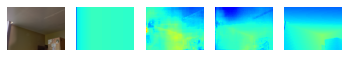

308


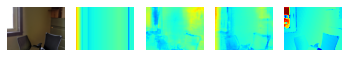

309


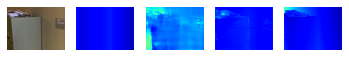

310


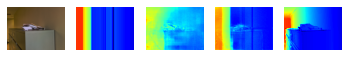

311


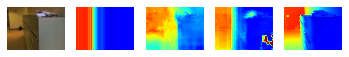

312


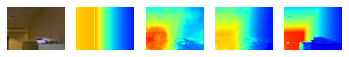

313


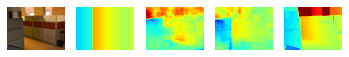

314


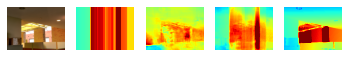

315


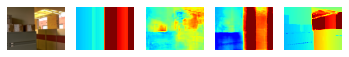

316


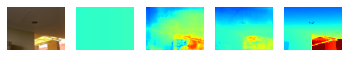

317


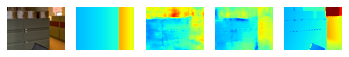

318


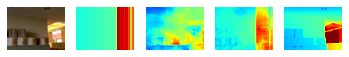

319


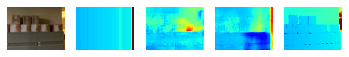

320


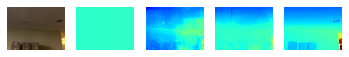

321


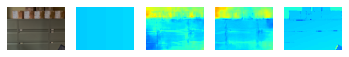

322


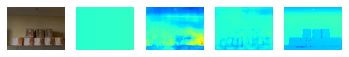

323


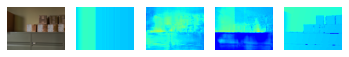

324


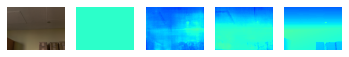

In [57]:
for i in range(300, len(val_rgb)):
    print(i)
    display_images(val_rgb[i], interp_preds[i], lidarless_preds[i], lidar_preds[i], val_depth[i])

In [44]:
val_depth_scan.shape

(325, 192, 256, 1)

In [ ]:
for i in range(300, len(val_rgb)):
    print(i)
    display_images(val_rgb[i], interp_preds[i], lidarless_preds[i], lidar_preds[i], val_depth[i])

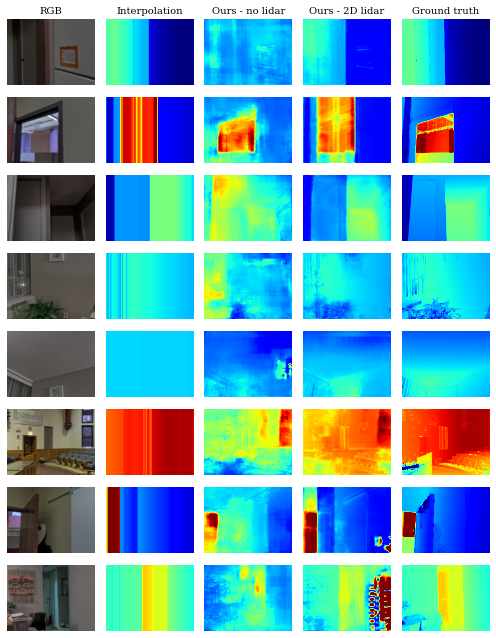

In [92]:
depths = [interp_preds, lidarless_preds, lidar_preds, val_depth]
val_indices = [161, 254, 169, 177, 179, 0, 211, 192]

fig, ax = plt.subplots(len(val_indices), 1 + len(depths), figsize=(7, 9))
for i in range(1 + len(depths)):
    for j in range(len(val_indices)):
        pass
        ax[j][i].set_axis_off()

for j in range(len(val_indices)):
    ax[j][0].imshow(val_rgb[val_indices[j]])

    with np.errstate(divide="ignore"):
        for i, d in enumerate(depths):
            args = ds_args(d[val_indices[j]])
            ax[j][i + 1].imshow(args[0], **args[1])
            
for axis, col in zip(ax[0], ["RGB", "Interpolation", "Ours - no lidar", "Ours - 2D lidar", "Ground truth"]):
    axis.set_title(col, fontfamily="serif", fontsize=10)

for axis, row in zip(ax[:,0], [f"({chr(i + ord('a'))})" for i in range(len(val_indices))]):
    axis.set_ylabel(row, rotation=0, fontfamily="serif", fontsize=10)

# plt.setp(ax.flat, xlabel='X-label', ylabel='Y-label')

# pad = 5 # in points

# for axis, col in zip(ax[0], ["RGB", "Interpolation", "Ours - no lidar", "Ours - 2D lidar", "Ground truth"]):
#     axis.annotate(col, xy=(0.5, 1), xytext=(0, pad),
#                   xycoords='axes fraction', textcoords='offset points',
#                   size='large', ha='center', va='baseline')

# for axis, row in zip(ax[:,0], [f"({chr(i + ord('a'))})" for i in range(len(val_indices))]):
#     axis.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                   xycoords=ax.yaxis.label, textcoords='offset points',
#                   size='large', ha='right', va='center')

plt.tight_layout()

plt.savefig("output/samples/samples.pgf")
plt.show()

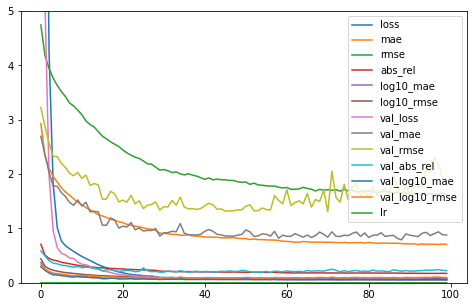

In [100]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.ylim(0, 5)
plt.show()

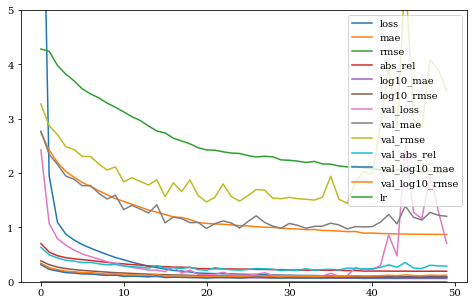

In [21]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.ylim(0, 5)
plt.show()

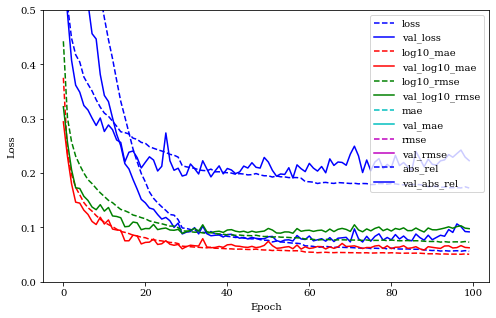

In [143]:
def p(name, style):
    plt.plot(history.history[name], style, label=name)

p('loss', "b--")
p('val_loss', "b-")
p('log10_mae', "r--")
p('val_log10_mae', "r-")
p('log10_rmse', "g--")
p('val_log10_rmse', "g-")
p('mae', "c--")
p('val_mae', "c-")
p('rmse', "m--")
p('val_rmse', "m-")
p('abs_rel', "b--")
p('val_abs_rel', "b-")

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.ylim(-0, 0.5)
plt.show()

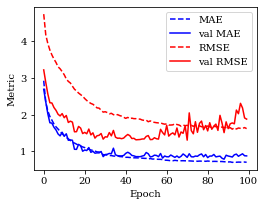

In [140]:
def p(name, label, style):
    plt.plot(history.history[name], style, label=label)

fig = plt.figure(figsize=(4, 3))

p('mae', "MAE", "b--")
p('val_mae', "val MAE", "b-")
p('rmse', "RMSE", "r--")
p('val_rmse', "val RMSE", "r-")

plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
# plt.ylim(0, 5)
plt.savefig("output/training_curve.pgf")
plt.show()

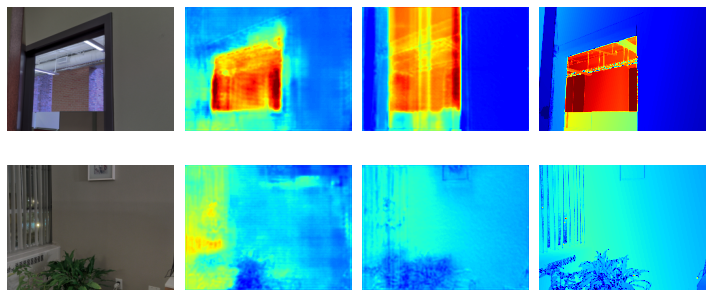

In [15]:
depths = [lidarless_preds, lidar_preds, val_depth]
val_indices = [254, 177]

fig, ax = plt.subplots(len(val_indices), 1 + len(depths), figsize=(10, 5))
for i in range(1 + len(depths)):
    for j in range(len(val_indices)):
        pass
        ax[j][i].set_axis_off()

for j in range(len(val_indices)):
    ax[j][0].imshow(val_rgb[val_indices[j]])

    with np.errstate(divide="ignore"):
        for i, d in enumerate(depths):
            args = ds_args(d[val_indices[j]])
            ax[j][i + 1].imshow(args[0], **args[1])
            
# for axis, col in zip(ax[0], ["RGB", "Interpolation", "Ours - no lidar", "Ours - 2D lidar", "Ground truth"]):
#     axis.set_title(col, fontfamily="serif", fontsize=10)

# for axis, row in zip(ax[:,0], [f"({chr(i + ord('a'))})" for i in range(len(val_indices))]):
#     axis.set_ylabel(row, rotation=0, fontfamily="serif", fontsize=10)

# plt.setp(ax.flat, xlabel='X-label', ylabel='Y-label')

# pad = 5 # in points

# for axis, col in zip(ax[0], ["RGB", "Interpolation", "Ours - no lidar", "Ours - 2D lidar", "Ground truth"]):
#     axis.annotate(col, xy=(0.5, 1), xytext=(0, pad),
#                   xycoords='axes fraction', textcoords='offset points',
#                   size='large', ha='center', va='baseline')

# for axis, row in zip(ax[:,0], [f"({chr(i + ord('a'))})" for i in range(len(val_indices))]):
#     axis.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                   xycoords=ax.yaxis.label, textcoords='offset points',
#                   size='large', ha='right', va='center')

plt.tight_layout()

plt.savefig("output/samples/samples.pgf")
plt.show()